In [72]:
## Deze logistieke regressie moet voorspellen of het gaat regenen of niet
## 1. Imports
# imports Dataframe
import pandas as pd
import numpy as np

# imports voor regressie
#from sklearn.preprocessing import scale
#from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as rianne
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier

# imports voor tekenen
import seaborn as sb; sb.set_theme(color_codes=True)

# Bestand data
filepath = os.path.join("Data.txt")

In [73]:
## 2. Initialiseer teken opmaak
# seaborn
sb.set(style="white")
sb.set(style="whitegrid", color_codes=True)

In [74]:
## 3. Import csv data
df = pd.read_csv(
    filepath, 
    parse_dates=['YYYYMMDD'],
    low_memory=False)[['YYYYMMDD','TX','TN','RH','UN', 'UX', 'PG', 'NG', 'VVX']]

# Periode van de mee te nemen data
df = df[(df['YYYYMMDD'] > '1950-12-31') & (df['YYYYMMDD'] < '2016-1-1')]

# Datum Verwijderen
df.drop(['YYYYMMDD'], axis=1, inplace=True)

#objecten weergeven in numerieke waarden
df = df.apply(pd.to_numeric, errors='coerce')

# Alle te gebruiken informatie tussen eind 1950 en begin 2016
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23741 entries, 0 to 23740
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TX      23698 non-null  float64
 1   TN      23698 non-null  float64
 2   RH      15950 non-null  float64
 3   UN      16436 non-null  float64
 4   UX      16436 non-null  float64
 5   PG      23706 non-null  float64
 6   NG      23381 non-null  float64
 7   VVX     21949 non-null  float64
dtypes: float64(8)
memory usage: 1.6 MB


In [75]:
## 4. verder filteren van de dataframe
#Benamingen veranderingen op de originele benamingen van de dataset
df = df.rename(columns = {'TX': 'MAX_TEMP', 'TN':'MIN_TEMP','RH': 'Regen','UN': 'MIN_HUM', 'UX':'MAX_HUM', 'PG': 'Luchtdruk', 'NG': 'bewolking', 'VVX': 'Zicht'}, inplace = False)

# De row met null waarden eruit filteren
df.dropna(subset = ["Regen"], inplace=True)
df.dropna(subset = ["bewolking"], inplace=True)
df.dropna(subset = ["Zicht"], inplace=True)

# Bij Neerslag is het getal tot 0.05mm negatief, daarna word het 0 of hoger
# Dus alles van 0.1 mm aan regenval tellen wij als ja, er was regen op deze dag.
# Regen word de nieuwe kolom die Neerslag vervangt
df['Regen'] = np.where(df['Regen']<=0, 0,1)

# Volledige rijen van informatie tussen 1950 en 2016
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15615 entries, 7791 to 23449
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MAX_TEMP   15615 non-null  float64
 1   MIN_TEMP   15615 non-null  float64
 2   Regen      15615 non-null  int32  
 3   MIN_HUM    15615 non-null  float64
 4   MAX_HUM    15615 non-null  float64
 5   Luchtdruk  15615 non-null  float64
 6   bewolking  15615 non-null  float64
 7   Zicht      15615 non-null  float64
dtypes: float64(7), int32(1)
memory usage: 1.0 MB


In [76]:
## tussendoor opvragen van informatie
# print(df.head(5))
# print(df.tail(5))
# print(df.isnull().sum())
print(df.corr()) # Correlaties tussen kolommen weergeven

           MAX_TEMP  MIN_TEMP     Regen   MIN_HUM   MAX_HUM  Luchtdruk  \
MAX_TEMP   1.000000  0.870388 -0.111141 -0.437398  0.007330  -0.001507   
MIN_TEMP   0.870388  1.000000  0.064653 -0.157347 -0.026424  -0.115789   
Regen     -0.111141  0.064653  1.000000  0.275176  0.139799  -0.458086   
MIN_HUM   -0.437398 -0.157347  0.275176  1.000000  0.439795  -0.102216   
MAX_HUM    0.007330 -0.026424  0.139799  0.439795  1.000000  -0.000740   
Luchtdruk -0.001507 -0.115789 -0.458086 -0.102216 -0.000740   1.000000   
bewolking -0.267589  0.050970  0.479604  0.581306  0.169089  -0.316692   
Zicht      0.277158  0.235460  0.048041 -0.458912 -0.267896  -0.068933   

           bewolking     Zicht  
MAX_TEMP   -0.267589  0.277158  
MIN_TEMP    0.050970  0.235460  
Regen       0.479604  0.048041  
MIN_HUM     0.581306 -0.458912  
MAX_HUM     0.169089 -0.267896  
Luchtdruk  -0.316692 -0.068933  
bewolking   1.000000 -0.220364  
Zicht      -0.220364  1.000000  


<AxesSubplot:xlabel='Regen', ylabel='count'>

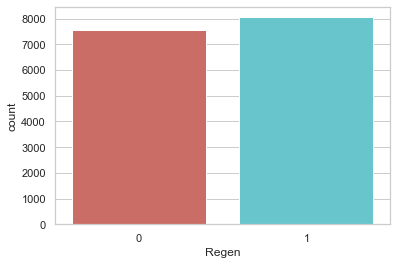

In [77]:
## Staafdiagrammen
# Weergeven van binaire waarden in de 'Regen' kollom. 
# Hier wordt een telling weergegeven op hoeveel dagen het heeft geregent, en op hoeveel dagen het niet heeft geregent.
sb.countplot(
    x='Regen', 
    data=df, 
    palette= 'hls')

In [78]:
## 5. Initialisatie logistieke regressie waarden
# voor de kansberekening nemen we de kolom regen niet mee aan X
X = df.drop("Regen",axis=1)
y = df['Regen']

# X en Y splitsen we op in huidige waarden en testwaarden
# 80% wordt gebruikt als trainwaarden omdat collectie aan data zo groot is dat we nog steeds genoeg over houden als test waarden.
X_train, X_test, y_train, y_test = train_test_split(
    X,y, 
    test_size= 0.2, 
    random_state=1)
# max_iter is verhoogt om problemen te voorkomen bij grote dataframes
# Anders geeft python een Converence Warning als bericht
logReg = LogisticRegression(max_iter=1000)

logReg.fit(X,y)

# Klassificatie rapport van de test waarden, waarbij wordt weergegeven of de voorspelling legetiem is uitgedrukt in procenten.
predictions = logReg.predict(X_test)

In [79]:
## print score en classificatie
print(logReg.score(X,y))


0.7461415305795709


In [80]:
# Berekening percentage:
#  (1020+1296)\(469+338+1020+1296) ≈ 75% score
print(classification_report(y_test, predictions))
# Overzicht testwaarden voor score berekeningen
rianne(y_test,predictions)
# Zuiverheids score
accuracy_score(y_test, predictions)


              precision    recall  f1-score   support

           0       0.75      0.69      0.72      1489
           1       0.73      0.79      0.76      1634

    accuracy                           0.74      3123
   macro avg       0.74      0.74      0.74      3123
weighted avg       0.74      0.74      0.74      3123



0.7415946205571565

Text(0, 0.5, 'Regen in wel of geen')

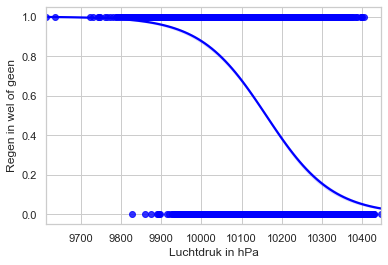

In [81]:
## 6. Tekenen voorspellingen Logistieke regressies
# n_boot zorgt voor meer resamples, er was geen zichtbaar verschil boven de 25 dus laten we de regressie op 25 staan

sb.regplot(
    x="Luchtdruk", 
    y="Regen", 
    data=df,
    n_boot=25,
    logistic=True, 
    color='blue')
plt.xlabel('Luchtdruk in hPa')
plt.ylabel('Regen in wel of geen')

In [82]:
# Regen was uitgedrukt in wel of geen regen, vandaar 0 of 1
# Luchtdruk was uitgedrukt in hPa

Text(0, 0.5, 'Regen in wel of geen')

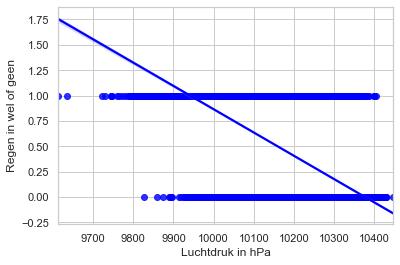

In [84]:
# Hieronder staat een lineaire regressie die onderbouwt dat je met luchtdruk en regen een logistieke regressie kan uitvoeren.
sb.regplot(
    x='Luchtdruk', 
    y='Regen', 
    data=df,
    n_boot=25,
    color= 'blue', 
    scatter= True)
plt.xlabel('Luchtdruk in hPa')
plt.ylabel('Regen in wel of geen')

In [85]:
## Dit was de logistieke regressie
## We kunnen uit de Logistieke regressie aflezen dat er zo'n 50% kans op regen zou zijn wanneer de luchtdruk druk op ongeveer 10150 hPa bar zou staan


In [ ]:
# hier een link voor de making off https://www.youtube.com/watch?v=xvFZjo5PgG0